##### Copyright 2018 The TensorFlow Authors.
inspired from Tensorflow Tutorial for ImageDateGenerator and augmentation Dogs&Cats

In [37]:
import tensorflow as tf

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # it has not great performance comapred to dataset 
## see https://www.tensorflow.org/tutorials/load_data/images

import os
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)

In [123]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import itertools
import sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [39]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [40]:
PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/data/'

(IMG_HEIGHT, IMG_WIDTH)=(227,227) # to be determined for the pretrained

In [140]:
#how many
num_covid = len(os.listdir(os.path.join(os.path.dirname(PATH), 'COVID-19')))
num_normal = len(os.listdir(os.path.join(os.path.dirname(PATH), 'NORMAL')))
num_viral = len(os.listdir(os.path.join(os.path.dirname(PATH), 'ViralPneumonia')))
num_covid,num_normal,num_viral  # imbalanced!!!!! maybe before DataGenerator we should split with stratified version from scikit


(219, 1341, 1345)

## Load data

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255,
        validation_split=0.2)

train_data_gen = train_datagen.flow_from_directory(batch_size=32,color_mode= "grayscale",
                                                           directory=PATH,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse', subset='training')

Found 2325 images belonging to 3 classes.


In [139]:
covid=len(np.where(train_data_gen.classes==0)[0])
normal= len(np.where(train_data_gen.classes==1)[0])
viral= len(np.where(train_data_gen.classes==2)[0])
covid, normal, viral

(176, 1073, 1076)

In [111]:
val_data_gen = train_datagen.flow_from_directory(batch_size=32,
                                                              directory=PATH,color_mode= "grayscale",
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              shuffle=False,
                                                              class_mode='sparse', subset='validation')

Found 580 images belonging to 3 classes.


In [44]:
total_train = 2325
total_val=580
batch_size=32

### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [45]:
sample_training_images, labels = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [189]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax,l in zip( images_arr, axes, labels):
        ax.imshow(img.reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
        ax.axis('off')
        ax.set_title(l, loc='center', y=1.1)
    plt.tight_layout()
    plt.show()

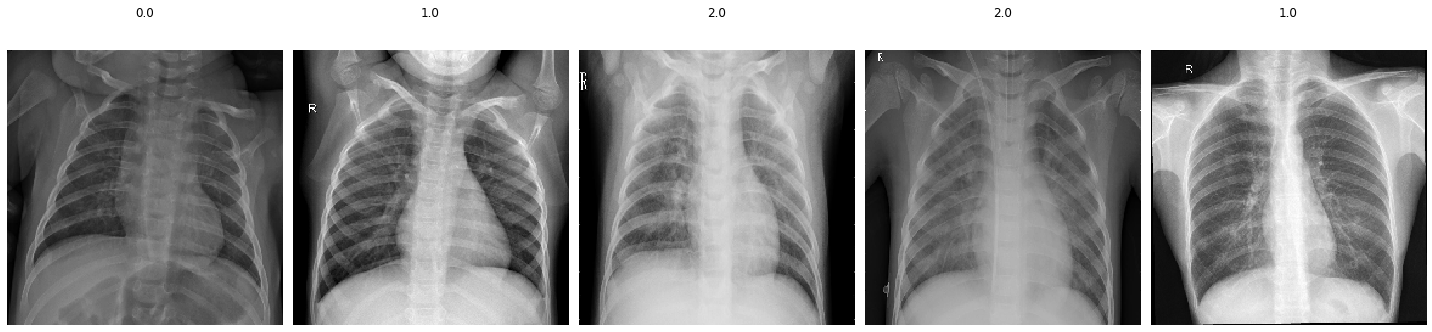

In [190]:
plotImages(sample_training_images[:5], labels[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [176]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

In [145]:
total_train = covid+normal+viral
weight_for_0 = (1 / covid)*total_train/3.0 
weight_for_1 = (1 / normal)*total_train/3.0
weight_for_2 = (1 / viral)*total_train/3.0
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}
print(class_weight)
total_val=len(val_data_gen.classes)
print(total_train, total_val)

{0: 4.403409090909091, 1: 0.7222739981360671, 2: 0.720260223048327}
2325 580


### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [177]:
METRICS = [tf.keras.metrics.Precision(name='precision', top_k=1),
    tf.keras.metrics.Precision(name='precision', top_k=3),
    tf.keras.metrics.Recall(name='recall', top_k=1),
    tf.keras.metrics.Recall(name='recall', top_k=3)]

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [178]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 227, 227, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 113, 113, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 113, 113, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [179]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=12,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size, 
    class_weight=class_weight
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 72 steps, validate for 18 steps
Epoch 1/12
72/72 [==============================] - 35s 491ms/step - loss: 0.7095 - accuracy: 0.7178 - val_loss: 0.4972 - val_accuracy: 0.8993
Epoch 2/12
72/72 [==============================] - 35s 484ms/step - loss: 0.2079 - accuracy: 0.9171 - val_loss: 0.2123 - val_accuracy: 0.9288
Epoch 3/12
72/72 [==============================] - 35s 488ms/step - loss: 0.1393 - accuracy: 0.9498 - val_loss: 0.2081 - val_accuracy: 0.9444
Epoch 4/12
72/72 [==============================] - 35s 486ms/step - loss: 0.0905 - accuracy: 0.9603 - val_loss: 0.3523 - val_accuracy: 0.9201
Epoch 5/12
72/72 [==============================] - 35s 491ms/step - loss: 0.0705 - accuracy: 0.9695 - val_loss: 0.2055 - val_accuracy: 0.9583
Epoch 6/12
72/72 [==============================] - 36s 493ms/step - loss: 0.0615 - accuracy: 0.9712 - val_loss: 0.2654 - val_accuracy: 0.9340
Epoch 7/12
72/72 [==============================] 

### Visualize training results

Now visualize the results after training the network.

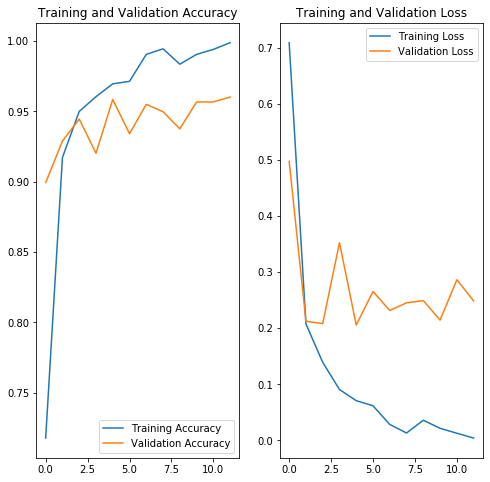

In [181]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

32/32 [==============================] - 0s 518us/sample


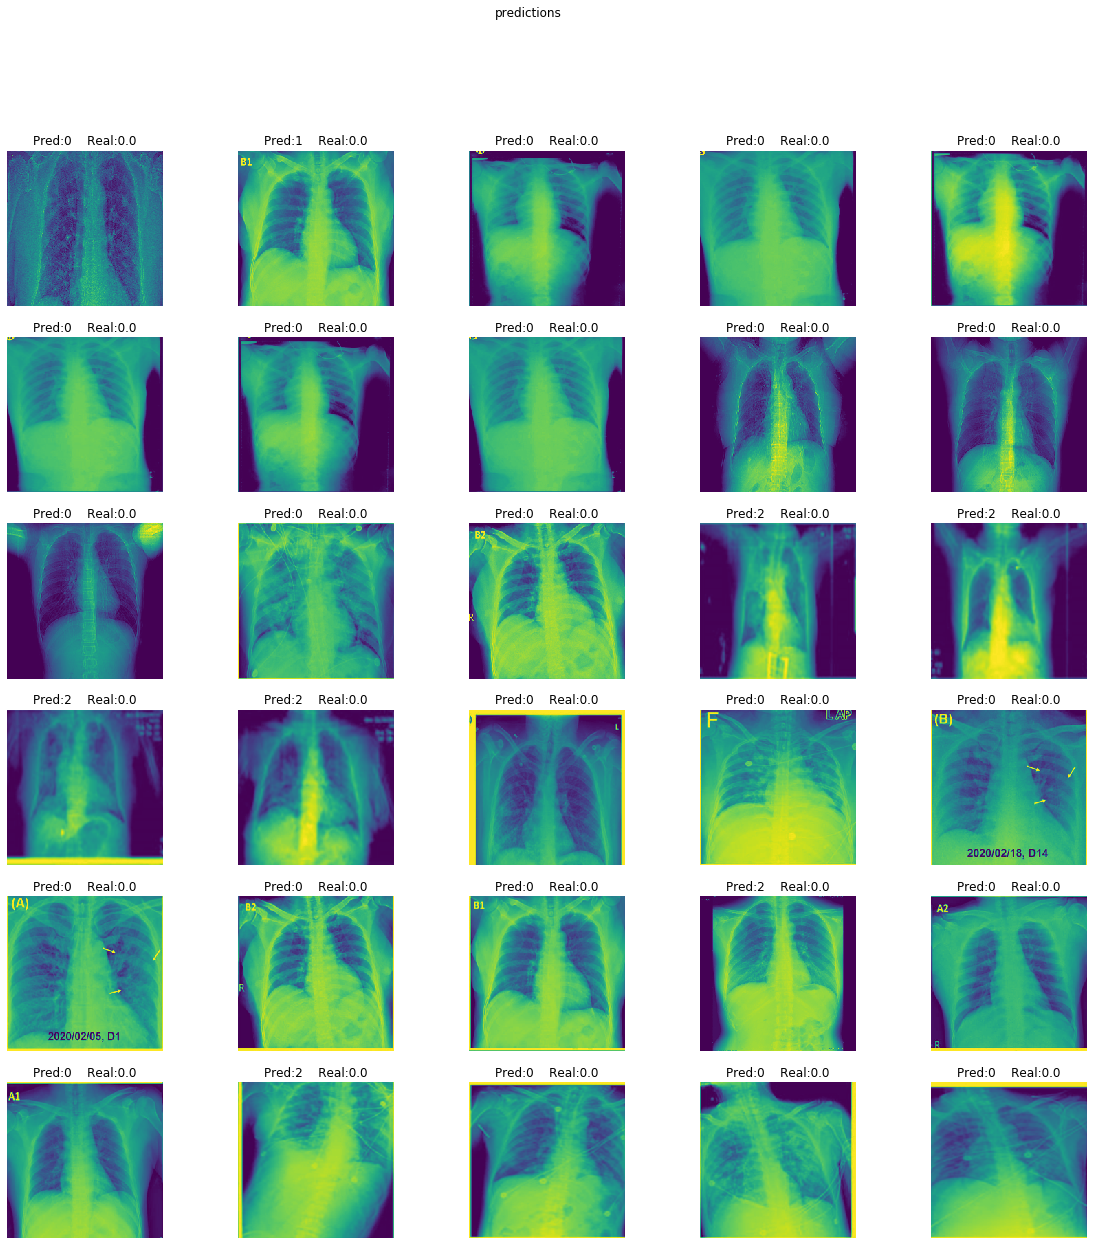

In [191]:
val_data_gen.reset() # in order to start from the beggining of the vaidation set

#only for a batch
#you can run it many times, it will apply on different batch

for image_batch, label_batch in val_data_gen:
  #print("Image batch shape: ", image_batch.shape)
  #print("Label batch shape: ", label_batch)
  break
pred=model.predict(image_batch,verbose=1) #only for the current batch

predicted_class_indices=np.argmax(pred,axis=1)
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.2)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n].reshape((IMG_HEIGHT, IMG_WIDTH)))
  plt.title("Pred:"+str(predicted_class_indices[n]) +"    Real:"+str(label_batch[n]))
  plt.axis('off')
_ = plt.suptitle("predictions")

In [184]:
#entire dataset
val_data_gen.reset()
#score = model.evaluate(val_data_gen, verbose=1)
#print(score)

In [185]:
pred=model.predict(val_data_gen,verbose=1)

19/19 [==============================] - 7s 353ms/step



              precision    recall  f1-score   support

       covid       0.87      0.79      0.83        43
      normal       0.98      0.97      0.98       268
       viral       0.96      0.97      0.97       269

    accuracy                           0.96       580
   macro avg       0.94      0.91      0.92       580
weighted avg       0.96      0.96      0.96       580



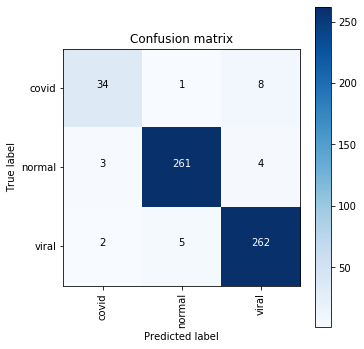

In [186]:

val_data_gen.classes
pred_indices = np.argmax(pred,axis=1)
confusion_mtx = confusion_matrix(val_data_gen.classes, pred_indices) 
plot_confusion_matrix(confusion_mtx, ['covid', 'normal', 'viral'] )
print('\n', sklearn.metrics.classification_report(val_data_gen.classes, pred_indices, target_names=['covid', 'normal', 'viral']), sep='') 

In [193]:
model.save('/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/models/simple_model')

INFO:tensorflow:Assets written to: /mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/models/simple_model/assets
